<a href="https://colab.research.google.com/github/dornercr/INFO371/blob/main/INFO371_week8_Probabilistic_Model_NaiveBayes_physics_vs_chem_vs_bio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INFO 371: Data Mining Applications

## Week 8: Probabilitic Model and Naive Bayes
### Prof. Charles Dorner, EdD (Candidate)
### College of Computing and Informatics, Drexel University

# A probabilistic classifier:
- Given an observation of an input
- Predict a probability distribution over a set of classes
- rather than only outputting the most likely class that the observation should belong to.

## For example,
- Given an Email as a text document:
 - $Pr(Spam|Email)$ = 0.7
 - $Pr(Not\_Spam|Email)$| = 0.3


# Bayes' Theorem in the Context of Data Mining

\begin{equation}
P(H \mid D) = \frac{P(D \mid H) P(H)}{P(D)}
\end{equation}

- $P(H∣D)$: Posterior Probability: The probability of hypothesis
$𝐻$ (e.g., a model or pattern being true) given the observed data $𝐷$.

- $P(D∣H)$: Likelihood: The probability of the data occurring given that hypothesis $𝐻$. In data mining, this represents how well the data supports a specific model.

- $P(H)$: Prior Probability: The initial belief about hypothesis
$𝐻$ before observing the data. In data mining, this may come from domain knowledge or historical patterns.

- $P(D)$: Evidence (Marginal Probability of Data): The overall probability of observing the data, regardless of which hypothesis is true. This acts as a normalizing factor.


# Probability Rules for Two Events \( A \) and \( B \)

## 1. Mutually Exclusive Events
Two events \( A \) and \( B \) are **mutually exclusive** if they cannot occur together. That is:

$$
P(A \cap B) = 0
$$

Using the addition rule:

$$
P(A \cup B) = P(A) + P(B)
$$

## 2. Not Mutually Exclusive Events
If \( A \) and \( B \) are **not mutually exclusive**, they can occur together. The general addition rule applies:

$$
P(A \cup B) = P(A) + P(B) - P(A \cap B)
$$

## 3. Independent Events
Two events \( A \) and \( B \) are **independent** if the occurrence of one does not affect the probability of the other. This means:

$$
P(A \cap B) = P(A) P(B)
$$

## 4. Dependent Events
If \( A \) and \( B \) are **dependent**, the probability of one event depends on the occurrence of the other. The conditional probability rule applies:

$$
P(A \cap B) = P(A \mid B) P(B) = P(B \mid A) P(A)
$$


In [2]:
# === INFO 371 – Week 8: Probabilistic Model and Naive Bayes ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from collections import Counter
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print("🔹 Libraries loaded successfully.")

# Load SpaCy and stemmer
nlp = spacy.load("en_core_web_sm")
stemmer = PorterStemmer()
print("🔹 SpaCy and stemmer initialized.")

# === A. Naive Bayes Toy Example ===
print("\n=== A. Toy Example Sentiment Classification ===")
s = {
    "The author is making big money": 1,
    "Irony but fascinating": 1,
    "don’t waste money on it": 0
}

word_freq_pos = Counter()
word_freq_neg = Counter()

for sentence in s:
    doc = nlp(sentence.lower())
    words = [stemmer.stem(token.lemma_.lower()) for token in doc if token.is_alpha]
    if s[sentence] == 1:
        word_freq_pos.update(words)
    else:
        word_freq_neg.update(words)

print("✅ Word frequencies calculated for toy dataset.")

word_prob_pos = {word: c / sum(word_freq_pos.values()) for word, c in word_freq_pos.items()}
word_prob_neg = {word: c / sum(word_freq_neg.values()) for word, c in word_freq_neg.items()}

print("✅ Conditional probabilities computed.")

# Classify: "money wasted, fascinated"
ss = "money wasted, fascinated"
doc = nlp(ss.lower())
words = [stemmer.stem(token.lemma_.lower()) for token in doc if token.is_alpha]

Pr_1 = np.prod([word_prob_pos.get(w, 1e-6) for w in words])
Pr_0 = np.prod([word_prob_neg.get(w, 1e-6) for w in words])
Pr_1_norm = Pr_1 / (Pr_1 + Pr_0)
Pr_0_norm = Pr_0 / (Pr_1 + Pr_0)

print("🔍 Sentence classified using manual Naive Bayes:")
print("Sentence:", ss)
print("Pr(pos|s):", round(Pr_1_norm, 4))
print("Pr(neg|s):", round(Pr_0_norm, 4))

# === B. Full Naive Bayes Classifier Using CSV ===
print("\n=== B. Real Dataset Classifier from CSV ===")
df = pd.read_csv("train.csv")
print(f"📂 Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print("🧾 First few rows:")
print(df.head())

# Preprocessing function
def spacy_tokenizer(sentence):
    doc = nlp(str(sentence))
    tokens = [stemmer.stem(token.lemma_.lower().strip()) for token in doc if not token.is_stop and token.is_alpha]
    return tokens

print("🔧 Custom tokenizer ready.")

# Vectorization
vectorizer = CountVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1,1))
X = vectorizer.fit_transform(df['Comment'])
y = df['Topic'].astype('category').cat.codes
print(f"📊 Vectorization complete. Shape of X: {X.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print("🧪 Data split: 80% train, 20% test")

# Train Naive Bayes
clf = MultinomialNB()
clf.fit(X_train, y_train)
print("✅ Model trained using Multinomial Naive Bayes")

# Cross-validation
cv_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy')
print("\n📈 Cross-Validation Scores:", cv_scores)
print("📊 Mean CV Accuracy:", round(np.mean(cv_scores), 4))

# Evaluate on test set
preds = clf.predict(X_test)
print("\n🧾 Evaluation on Test Set")
print("Precision:", round(precision_score(y_test, preds, average='weighted'), 4))
print("Recall:", round(recall_score(y_test, preds, average='weighted'), 4))
print("F1 Score:", round(f1_score(y_test, preds, average='weighted'), 4))
print("Accuracy:", round(accuracy_score(y_test, preds), 4))


🔹 Libraries loaded successfully.
🔹 SpaCy and stemmer initialized.

=== A. Toy Example Sentiment Classification ===
✅ Word frequencies calculated for toy dataset.
✅ Conditional probabilities computed.
🔍 Sentence classified using manual Naive Bayes:
Sentence: money wasted, fascinated
Pr(pos|s): 0.2358
Pr(neg|s): 0.7642

=== B. Real Dataset Classifier from CSV ===
📂 Data loaded: 8695 rows, 3 columns
🧾 First few rows:
       Id                                            Comment      Topic
0   0x840  A few things. You might have negative- frequen...    Biology
1   0xbf0  Is it so hard to believe that there exist part...    Physics
2  0x1dfc                                     There are bees    Biology
3   0xc7e  I'm a medication technician. And that's alot o...    Biology
4   0xbba                     Cesium is such a pretty metal.  Chemistry
🔧 Custom tokenizer ready.


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


📊 Vectorization complete. Shape of X: (8695, 10350)
🧪 Data split: 80% train, 20% test
✅ Model trained using Multinomial Naive Bayes

📈 Cross-Validation Scores: [0.72054598 0.69230769 0.71028037 0.73184759 0.70596693]
📊 Mean CV Accuracy: 0.7122

🧾 Evaluation on Test Set
Precision: 0.7447
Recall: 0.7424
F1 Score: 0.7411
Accuracy: 0.7424


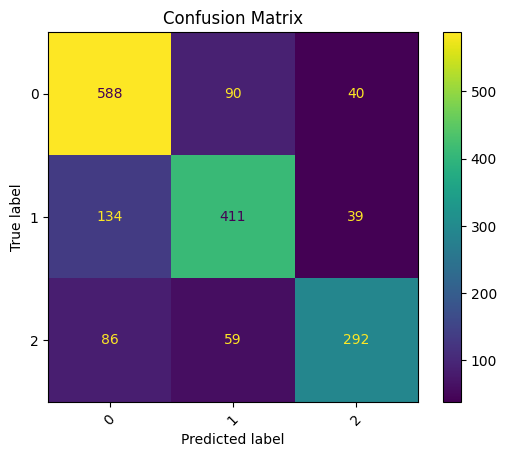

In [3]:
#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [5]:
#classification report per class
from sklearn.metrics import classification_report

target_names = [str(cls) for cls in clf.classes_]

print("=== Classification Report ===")
print(classification_report(y_test, preds, target_names=target_names))


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.73      0.82      0.77       718
           1       0.73      0.70      0.72       584
           2       0.79      0.67      0.72       437

    accuracy                           0.74      1739
   macro avg       0.75      0.73      0.74      1739
weighted avg       0.74      0.74      0.74      1739



In [8]:
#top predictive words per class
feature_names = vectorizer.get_feature_names_out()

for i, class_label in enumerate(clf.classes_):
    top10 = np.argsort(clf.feature_log_prob_[i])[-10:]
    print(f"\n🔍 Top words for class '{class_label}':")
    for j in top10[::-1]:
        print(f"  {feature_names[j]:<15} -> log-prob: {clf.feature_log_prob_[i][j]:.4f}")




🔍 Top words for class '0':
  like            -> log-prob: -4.6341
  think           -> log-prob: -5.2242
  know            -> log-prob: -5.2843
  look            -> log-prob: -5.3819
  peopl           -> log-prob: -5.3867
  thing           -> log-prob: -5.5989
  cell            -> log-prob: -5.6050
  need            -> log-prob: -5.6744
  get             -> log-prob: -5.7076
  find            -> log-prob: -5.7350

🔍 Top words for class '1':
  like            -> log-prob: -4.7758
  chemistri       -> log-prob: -5.2428
  work            -> log-prob: -5.2928
  think           -> log-prob: -5.3563
  know            -> log-prob: -5.3618
  good            -> log-prob: -5.3840
  use             -> log-prob: -5.5159
  acid            -> log-prob: -5.5552
  need            -> log-prob: -5.6241
  thank           -> log-prob: -5.6458

🔍 Top words for class '2':
  like            -> log-prob: -5.1295
  time            -> log-prob: -5.1542
  physic          -> log-prob: -5.1693
  think           -

In [ ]:
#analyze misclassified examples
misclassified = df.iloc[y_test.index][preds != y_test]
print("=== 🔎 Misclassified Examples ===")
print(misclassified[['Comment', 'Topic']].head(10))


# Use Scikit Learn Naive Bayes Classifier

```

```